
## Ocean Buoy Data

To complement the temperature data at the Livermore airport, here I download the ocean surface temperature data over the last 20 years from the [NOAA webpage for ocean buoy 46214](https://www.ndbc.noaa.gov/station_page.php?station=46214) off the coast, at the edge of the continental shelf.


In [2]:
import requests
import time
from pathlib import Path

# Base URL and station
base_url = "https://www.ndbc.noaa.gov/view_text_file.php"
station = "46214"

work = Path.home() / "Work"
lvk = work / "LVK_Temperature_Analysis"
data = lvk / "data"

# Download files for each year
for year in range(2004, 2024):
    # Construct URL
    params = {
        'filename': f'{station}h{year}.txt.gz',
        'dir': 'data/historical/stdmet/'
    }
    
    # Create output filename
    outfile = data / f'station_{station}_yr_{year}.txt'
    
    # Skip if file already exists
    if outfile.exists():
        print(f"Skipping {year} - file already exists")
        continue

    # Download file
    try:
        print(f"Downloading {year}...", end=' ')
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise error for bad status codes
        
        # Save content
        with open(outfile, 'w') as f:
            f.write(response.text)
        
        print("Success")
        
        # Be nice to the server
        time.sleep(1)
        
    except requests.RequestException as e:
        print(f"Failed: {e}")

print("Download complete!")

Skipping 2004 - file already exists
Skipping 2005 - file already exists
Skipping 2006 - file already exists
Skipping 2007 - file already exists
Skipping 2008 - file already exists
Skipping 2009 - file already exists
Skipping 2010 - file already exists
Skipping 2011 - file already exists
Skipping 2012 - file already exists
Skipping 2013 - file already exists
Skipping 2014 - file already exists
Skipping 2015 - file already exists
Skipping 2016 - file already exists
Skipping 2017 - file already exists
Skipping 2018 - file already exists
Skipping 2019 - file already exists
Skipping 2020 - file already exists
Skipping 2021 - file already exists
Skipping 2022 - file already exists
Skipping 2023 - file already exists
Download complete!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import numpy as np
import glob

# Read and process all station files
dfs = {}


for file in sorted(Path(data).glob('station_46214_yr_*.txt')):
    year = file.name.split('_yr_')[1].split('.')[0]
    
    try:
        # Read file, skipping header rows
        df = pd.read_csv(file, sep='\s+', skiprows=[1], comment='!')
        
        # Check if this is one of the years with different header format
        if year in ['2004', '2005', '2006']:
            yr_col = '#YYYY'
        else:
            yr_col = '#YY'

        # Convert date columns to datetime
        df['datetime'] = pd.to_datetime(
            df[yr_col].astype(str) + df['MM'].astype(str).str.zfill(2) + 
            df['DD'].astype(str).str.zfill(2) + df['hh'].astype(str).str.zfill(2),
            format='%Y%m%d%H'
        )
        
        # Calculate daily mean water temperature
        daily_temp = df.groupby(df['datetime'].dt.date)['WTMP'].mean()
        
        # Add month-day column for plotting
        daily_temp = pd.DataFrame(daily_temp)
        daily_temp['month_day'] = pd.to_datetime(daily_temp.index).strftime('%m-%d')
        
        dfs[year] = daily_temp
        
    except Exception as e:
        print(f"Error processing {year}: {e}")

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_21594/3572031574.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, sep='\s+', skiprows=[1], comment='!')


In [4]:
import gzip

df_2024 = {}

# Add Jan - Sep 2024 from gzipped files:
for file in sorted(Path(data).glob("46214*.txt.gz")):
    year = "2024" #file.name.split('h')[1].split('.')[0]
    
    try:
        # Read and decompress gzipped file
        with gzip.open(file, 'rt') as f:
            # Read file, skipping header rows
            df = pd.read_csv(f, sep='\s+', skiprows=[1], comment='!')
            
        yr_col = '#YY'

        # Convert date columns to datetime
        df['datetime'] = pd.to_datetime(
            df[yr_col].astype(str) + df['MM'].astype(str).str.zfill(2) + 
            df['DD'].astype(str).str.zfill(2) + df['hh'].astype(str).str.zfill(2),
            format='%Y%m%d%H'
        )
        
        # Calculate daily mean water temperature
        daily_temp = df.groupby(df['datetime'].dt.date)['WTMP'].mean()
        
        # Add month-day column for plotting
        daily_temp = pd.DataFrame(daily_temp)
        daily_temp['month_day'] = pd.to_datetime(daily_temp.index).strftime('%m-%d')
        
        df_2024[file.name] = daily_temp
        
    except Exception as e:
        print(f"Error processing {year}: {e}")
    
# Add Sep 2024 and last 45 days data from text files
for file in [data / 'station_46214_sep_2024.txt', data / 'station_46214_last_45_days.txt']:
    try:
        # Read file, skipping header rows
        df = pd.read_csv(file, sep='\s+', skiprows=[1], comment='!')
        
        yr_col = '#YY'

        # Convert date columns to datetime
        df['datetime'] = pd.to_datetime(
            df[yr_col].astype(str) + df['MM'].astype(str).str.zfill(2) + 
            df['DD'].astype(str).str.zfill(2) + df['hh'].astype(str).str.zfill(2),
            format='%Y%m%d%H'
        )
        
        # Calculate daily mean water temperature
        daily_temp = df.groupby(df['datetime'].dt.date)['WTMP'].mean()
        
        # Add month-day column for plotting
        daily_temp = pd.DataFrame(daily_temp)
        daily_temp['month_day'] = pd.to_datetime(daily_temp.index).strftime('%m-%d')
        
        df_2024[file] = daily_temp
        
    except Exception as e:
        print(f"Error processing {file}: {e}")
        
# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(df_2024.values()) #, keys=df_2024.keys()) #, names=['year'])

dfs["2024"] = combined_df


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_21594/3437120288.py:13: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(f, sep='\s+', skiprows=[1], comment='!')
/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_21594/3437120288.py:40: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, sep='\s+', skiprows=[1], comment='!')


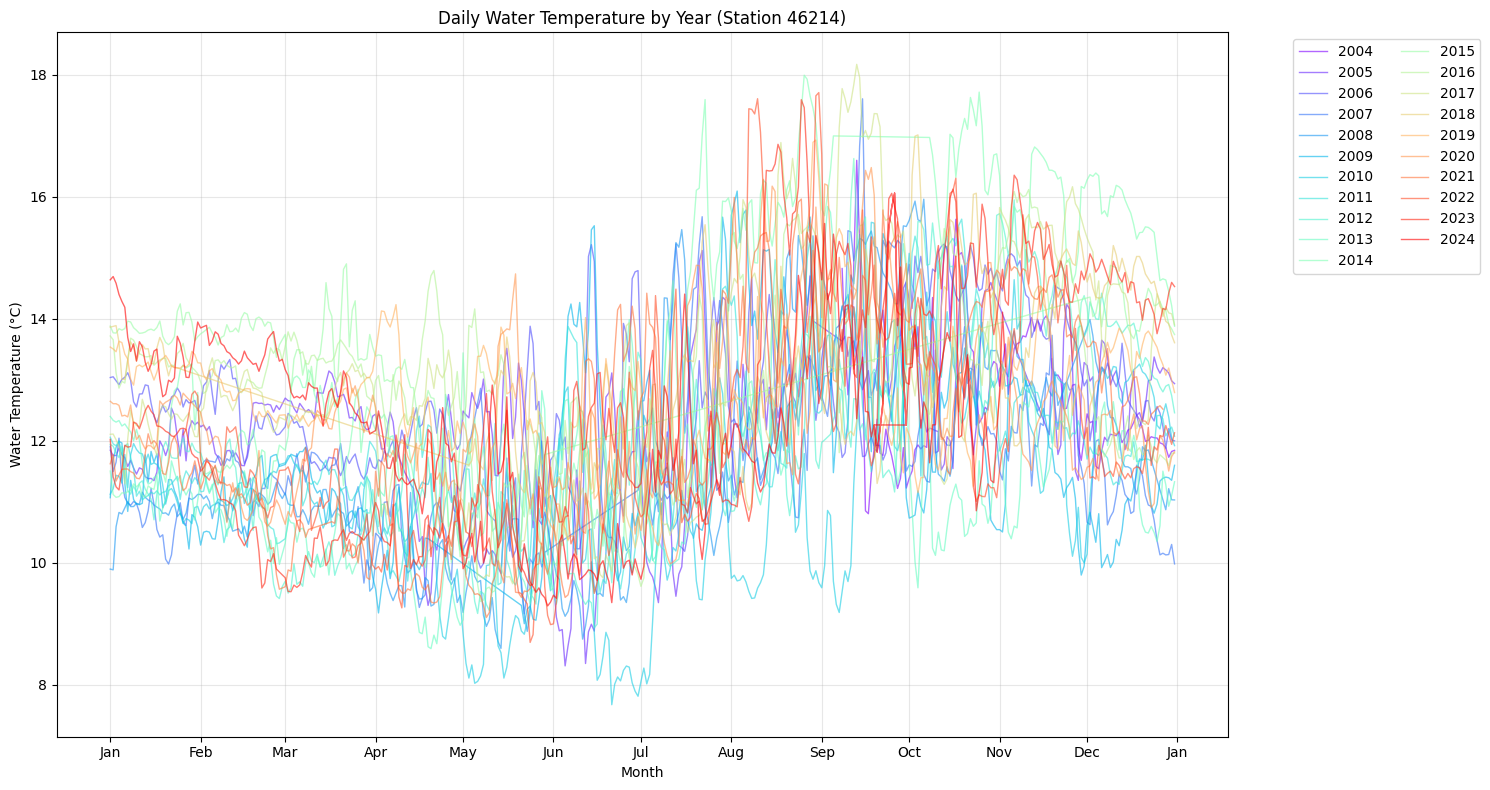

In [5]:
dfs_plot = dfs
# Subselect particular years for plotting:
#dfs_plot = {k: v for k, v in dfs.items() if k in ["2004", "2005", "2006", "2007"]} #["2014", "2015", "2017"]} #["2021", "2023", "2024"]}

# Create plot
plt.figure(figsize=(15, 8))

# Plot each year
# Use a brighter color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(dfs_plot)))
#colors = plt.cm.viridis(np.linspace(0, 1, len(dfs_plot)))
for (year, df), color in zip(dfs_plot.items(), colors):
    # Create x-axis values (day of year)
    x = pd.to_datetime('2000-' + df['month_day'])
    
    plt.plot(x, df['WTMP'], 
            label=year, 
            alpha=0.6,
            linewidth=1,
            color=color)

# Customize plot
plt.title('Daily Water Temperature by Year (Station 46214)')
plt.xlabel('Month')
plt.ylabel('Water Temperature (°C)')
plt.grid(True, alpha=0.3)

# Format x-axis to show months
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))

# Add legend (in two columns if many years)
if len(dfs) > 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [6]:
# Find temperatures exceeding 30°C across all years
high_temps = []
for year, df in dfs.items():
    # Get dates and temperatures where WTMP > 30
    extreme_temps = df[df['WTMP'] > 30]
    if not extreme_temps.empty:
        for date, row in extreme_temps.iterrows():
            high_temps.append({
                'Year': year,
                'Date': date,
                'Temperature': row['WTMP']
            })

# Convert to DataFrame and sort by temperature
if high_temps:
    extreme_df = pd.DataFrame(high_temps)
    extreme_df = extreme_df.sort_values('Temperature', ascending=False)
    print("\nDates with water temperature exceeding 30°C:")
    print(extreme_df)
else:
    print("\nNo temperatures exceeding 30°C were found in the dataset.")



No temperatures exceeding 30°C were found in the dataset.


Calculate a rolling mean and standard deviation for all years

In [7]:
all_temps = list(dfs.values())
combined_df = pd.concat(all_temps)

# Group by month-day to get all years' data for each calendar day
stats_df = combined_df.groupby('month_day')['WTMP'].agg(['mean', 'std', 'count']).reset_index()
stats_df['date'] = pd.to_datetime('2000-' + stats_df['month_day'])
stats_df = stats_df.sort_values('date')

# Calculate 5-day rolling statistics
window = 5
half_window = window // 2

rolling_stats = []
for i in range(len(stats_df)):
    # Get indices for 5-day window, handling wrap-around at year boundaries
    indices = [(i + j) % len(stats_df) for j in range(-half_window, half_window + 1)]
    
    # Get all temperatures for these dates across all years
    window_temps = []
    for idx in indices:
        md = stats_df.iloc[idx]['month_day']
        temps = combined_df[combined_df['month_day'] == md]['WTMP']
        window_temps.extend(temps.tolist())
    
    rolling_stats.append({
        'month_day': stats_df.iloc[i]['month_day'],
        'date': stats_df.iloc[i]['date'],
        'rolling_mean': np.mean(window_temps),
        'rolling_std': np.std(window_temps)
    })

rolling_df = pd.DataFrame(rolling_stats)


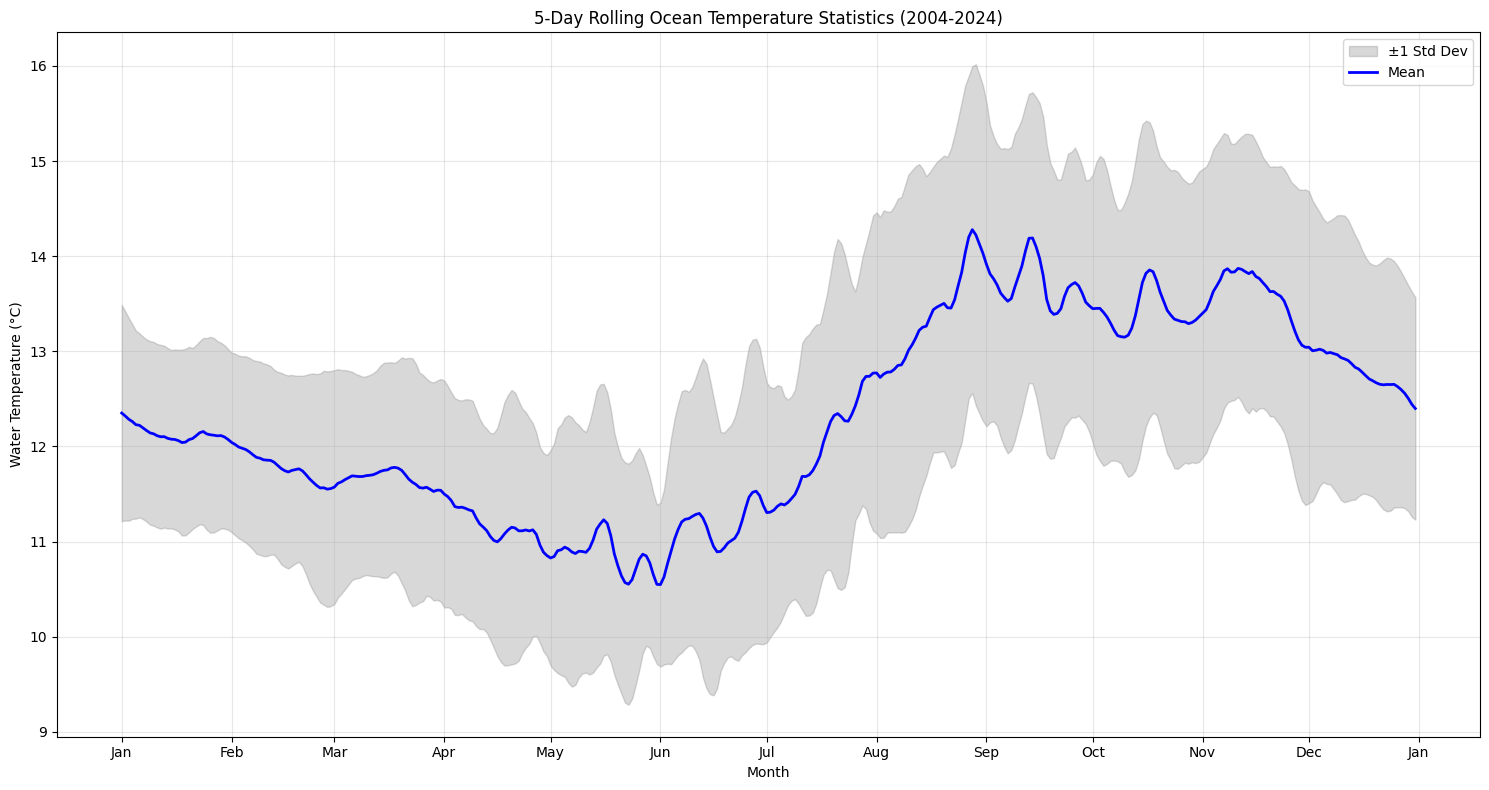

In [8]:
rolling_df = pd.DataFrame(rolling_stats)

# Plot the results
plt.figure(figsize=(15, 8))

# Plot mean and standard deviation range
plt.fill_between(rolling_df['date'],
                 rolling_df['rolling_mean'] - rolling_df['rolling_std'],
                 rolling_df['rolling_mean'] + rolling_df['rolling_std'],
                 alpha=0.3, color='gray', label='±1 Std Dev')

plt.plot(rolling_df['date'], rolling_df['rolling_mean'], 
         color='blue', linewidth=2, label='Mean')

# Customize plot
plt.title('5-Day Rolling Ocean Temperature Statistics (2004-2024)')
plt.xlabel('Month')
plt.ylabel('Water Temperature (°C)')
plt.grid(True, alpha=0.3)

# Format x-axis
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))

plt.legend()
plt.tight_layout()
plt.show()

Define a function to plot years on top of the rolling mean and standard deviation

In [9]:
# Standardize the x-axis data by converting rolling_df dates to month-day format
rolling_df['month_day'] = rolling_df['date'].dt.strftime('%m-%d')

# Update the plotting function to use consistent x-axis
def plot_years_vs_rolling_stats(years):
    """
    Plot specific years' temperature data overlaid on the rolling mean and std dev.
    Using consistent month-day format for x-axis.
    
    Args:
        years (list): List of year strings to plot (e.g. ["2004", "2005"])
    """
    plt.figure(figsize=(15, 8))
    
    # Create a reference date series for x-axis (using 2000 as arbitrary year)
    date_index = pd.to_datetime('2000-' + rolling_df['month_day'])
    
    # Plot rolling stats background
    plt.fill_between(date_index,
                     rolling_df['rolling_mean'] - rolling_df['rolling_std'],
                     rolling_df['rolling_mean'] + rolling_df['rolling_std'],
                     alpha=0.2, color='gray', label='±1 Std Dev')

    plt.plot(date_index, rolling_df['rolling_mean'],
             color='blue', linewidth=2, label='20-Year Mean')
    
    # Plot each requested year
    colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))
    for year, color in zip(years, colors):
        if year in dfs:
            year_data = dfs[year]
            # Convert month_day to datetime for consistent x-axis
            year_dates = pd.to_datetime('2000-' + year_data['month_day'])
            plt.plot(year_dates, year_data['WTMP'],
                    label=f'Year {year}', alpha=0.7,
                    color=color, linewidth=1.5)
    
    # Customize plot
    plt.title('Ocean Temperature Comparison with 20-Year Statistics')
    plt.xlabel('Month')
    plt.ylabel('Water Temperature (°C)')
    plt.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(MonthLocator())
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
    
    plt.legend()
    plt.tight_layout()
    plt.show()


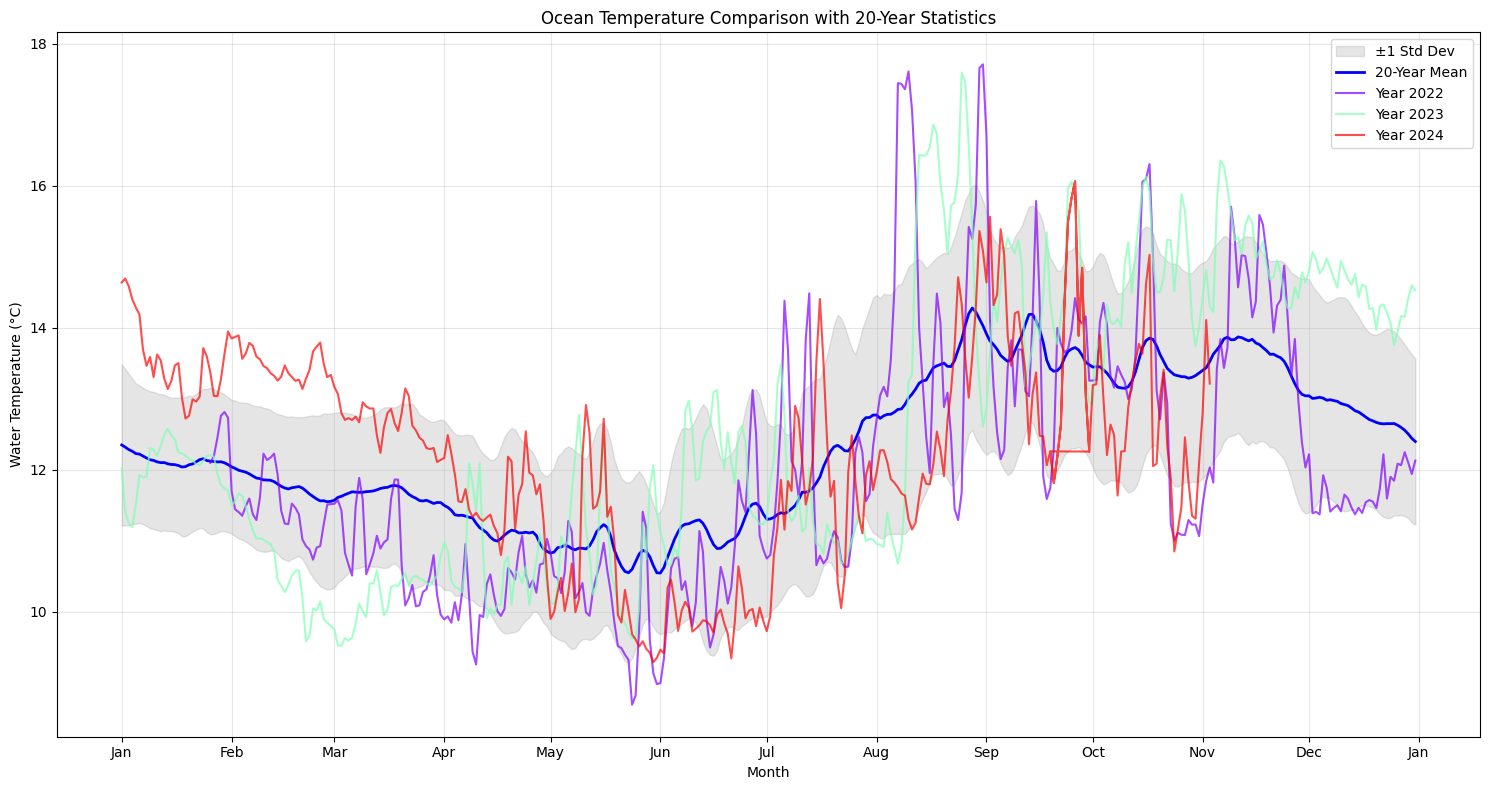

In [10]:
plot_years_vs_rolling_stats(['2022', '2023', '2024'])


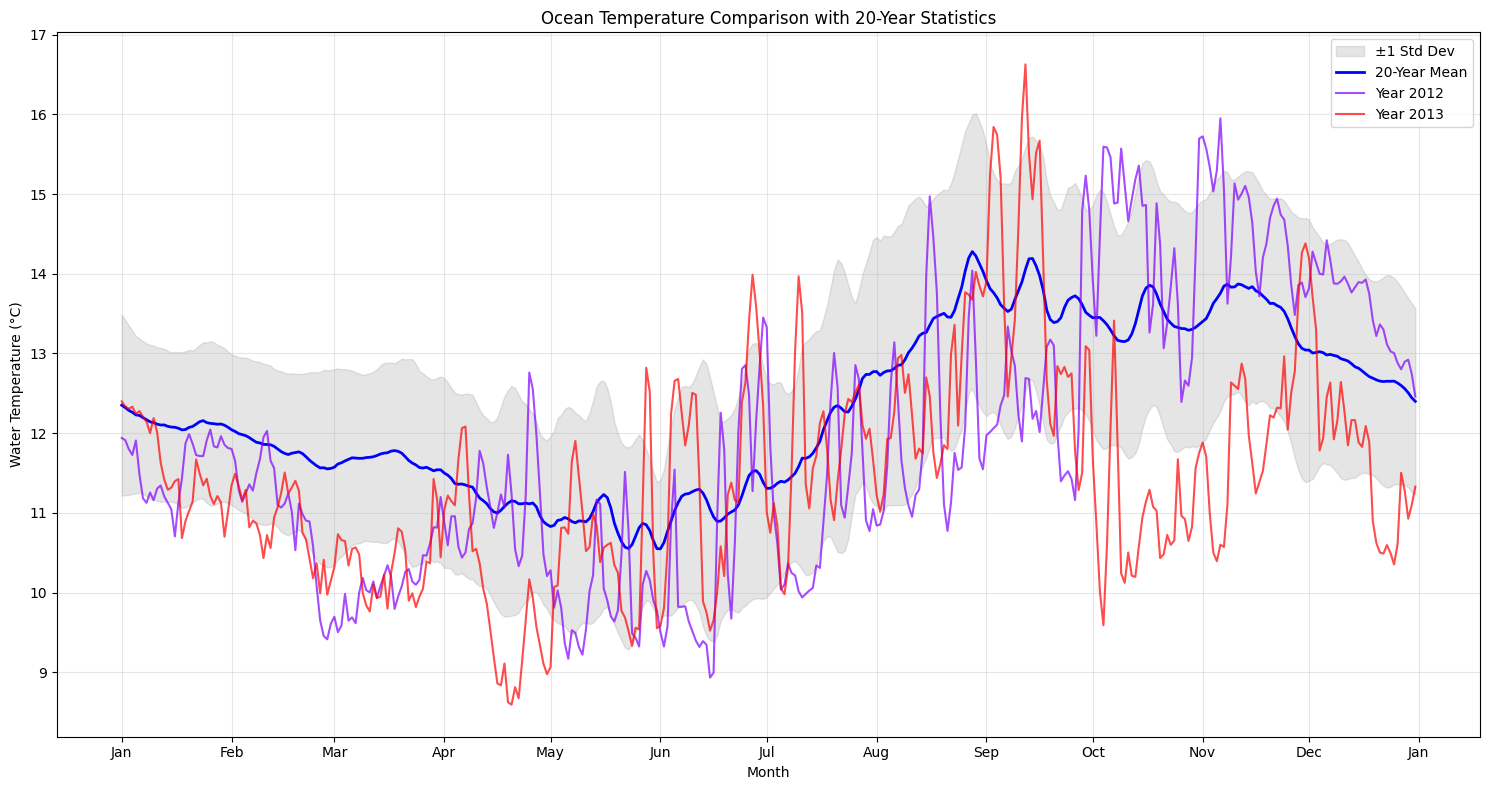

In [11]:
plot_years_vs_rolling_stats(['2012', '2013'])

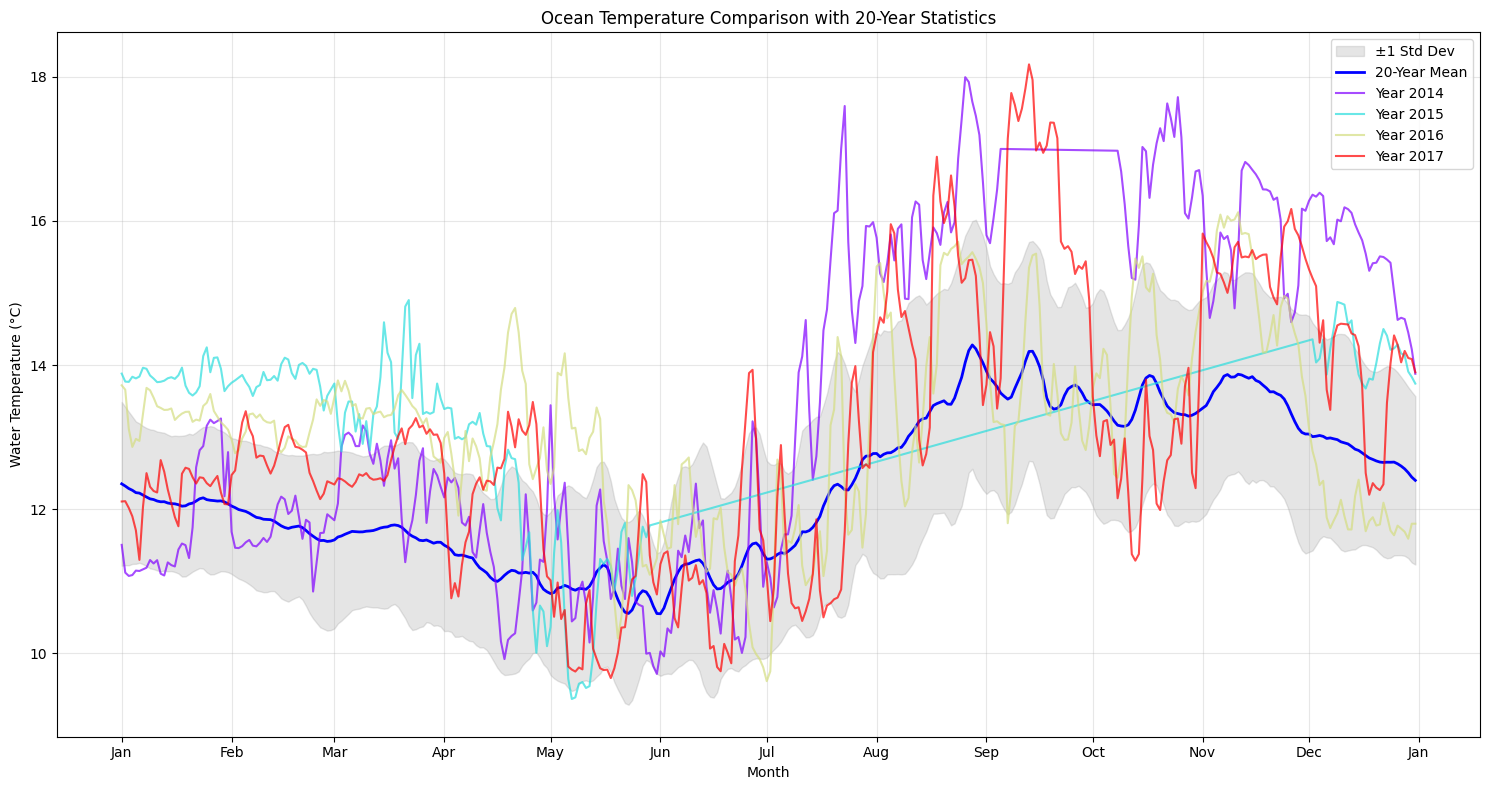

In [12]:
plot_years_vs_rolling_stats(['2014', '2015', '2016', '2017'])


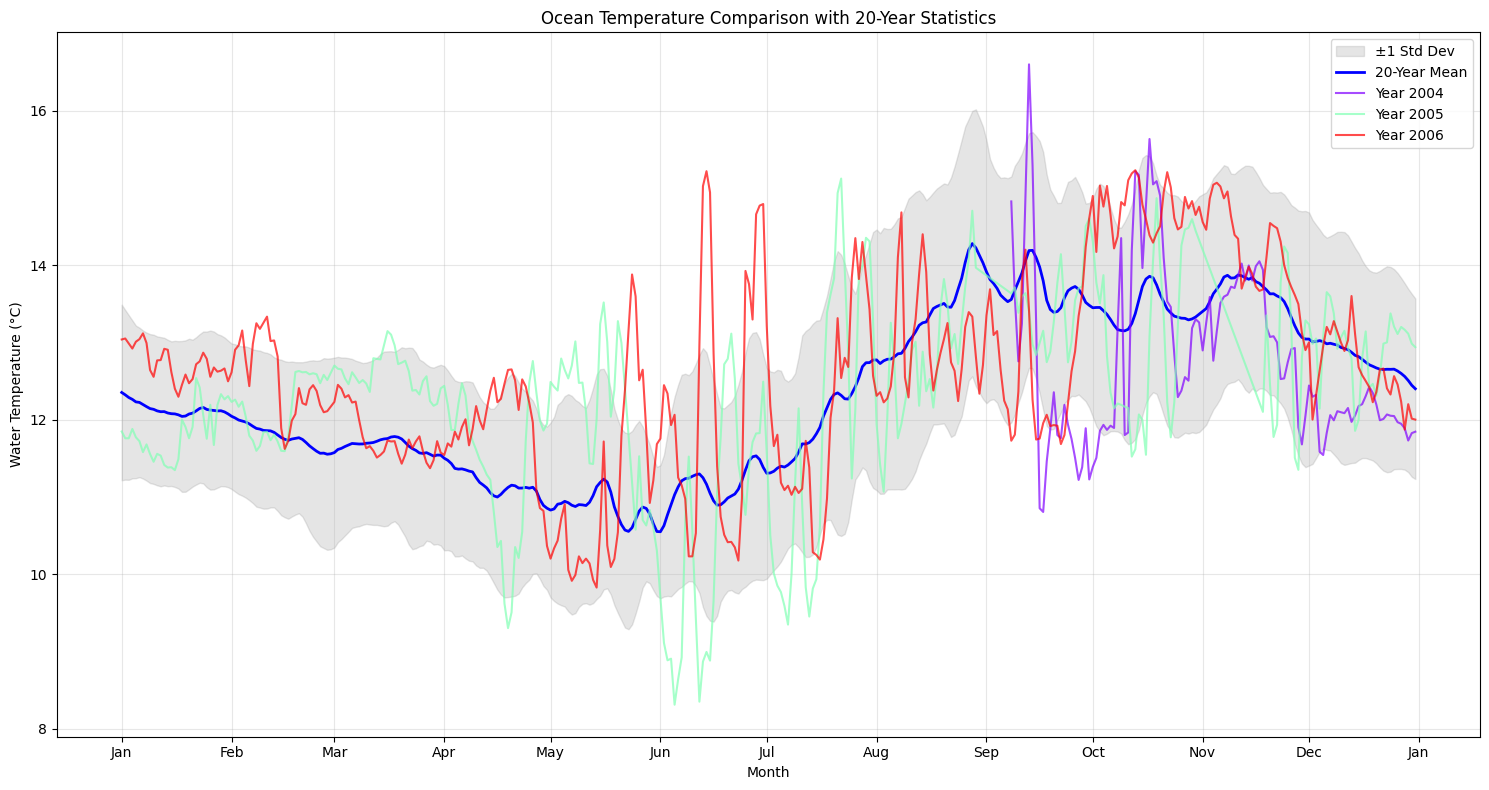

In [13]:
plot_years_vs_rolling_stats(['2004', '2005', '2006'])

---
## Calculate percentage of days exceeding mean + std for each month across all years

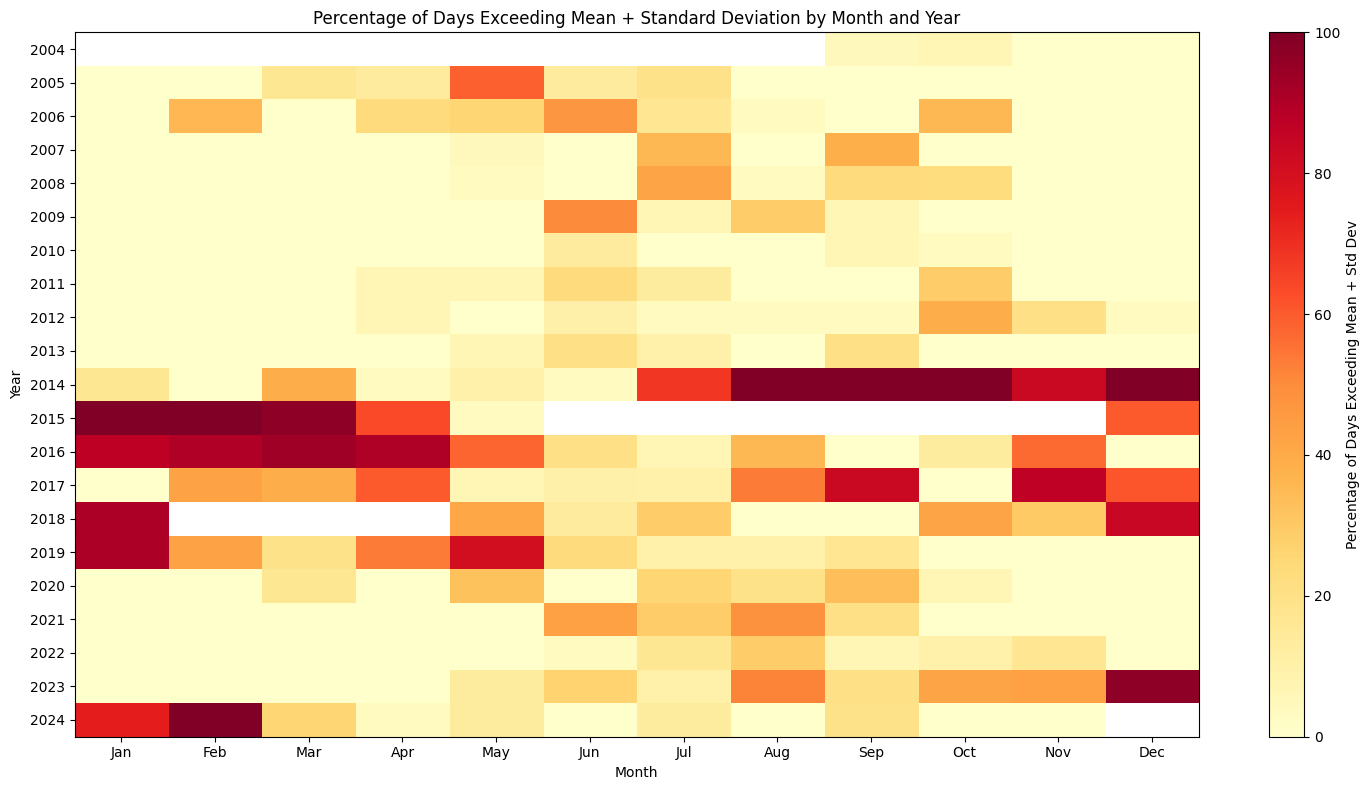

In [14]:
# Calculate percentage of days exceeding mean + std for each month across all years
monthly_exceedance = {}

for year in dfs:
    df = dfs[year]
    # Get month from month_day column
    df['month'] = pd.to_datetime('2000-' + df['month_day']).dt.month
    
    # Merge with rolling stats
    df = df.merge(rolling_df[['month_day', 'rolling_mean', 'rolling_std']], 
                 on='month_day', how='left')
    
    # Compare against rolling stats
    exceeds_threshold = df['WTMP'] > (df['rolling_mean'] + df['rolling_std'])
    
    # Calculate percentage for each month
    monthly_stats = exceeds_threshold.groupby(df['month']).agg(['count', 'sum'])
    monthly_stats['pct_exceeding'] = 100 * monthly_stats['sum'] / monthly_stats['count']
    
    # Store results
    monthly_exceedance[year] = monthly_stats['pct_exceeding']

# Convert to DataFrame for plotting
exceedance_df = pd.DataFrame(monthly_exceedance).T

# Create figure
plt.figure(figsize=(15, 8))

# Plot heatmap-style visualization
plt.imshow(exceedance_df, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Percentage of Days Exceeding Mean + Std Dev')

# Customize plot
plt.title('Percentage of Days Exceeding Mean + Standard Deviation by Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')

# Format axes
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks(range(len(dfs)), list(dfs.keys()))

plt.tight_layout()
plt.show()

/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_21594/3212619929.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2004-01-01', end='2024-12-31', freq='M')[:len(exceedance_series)]


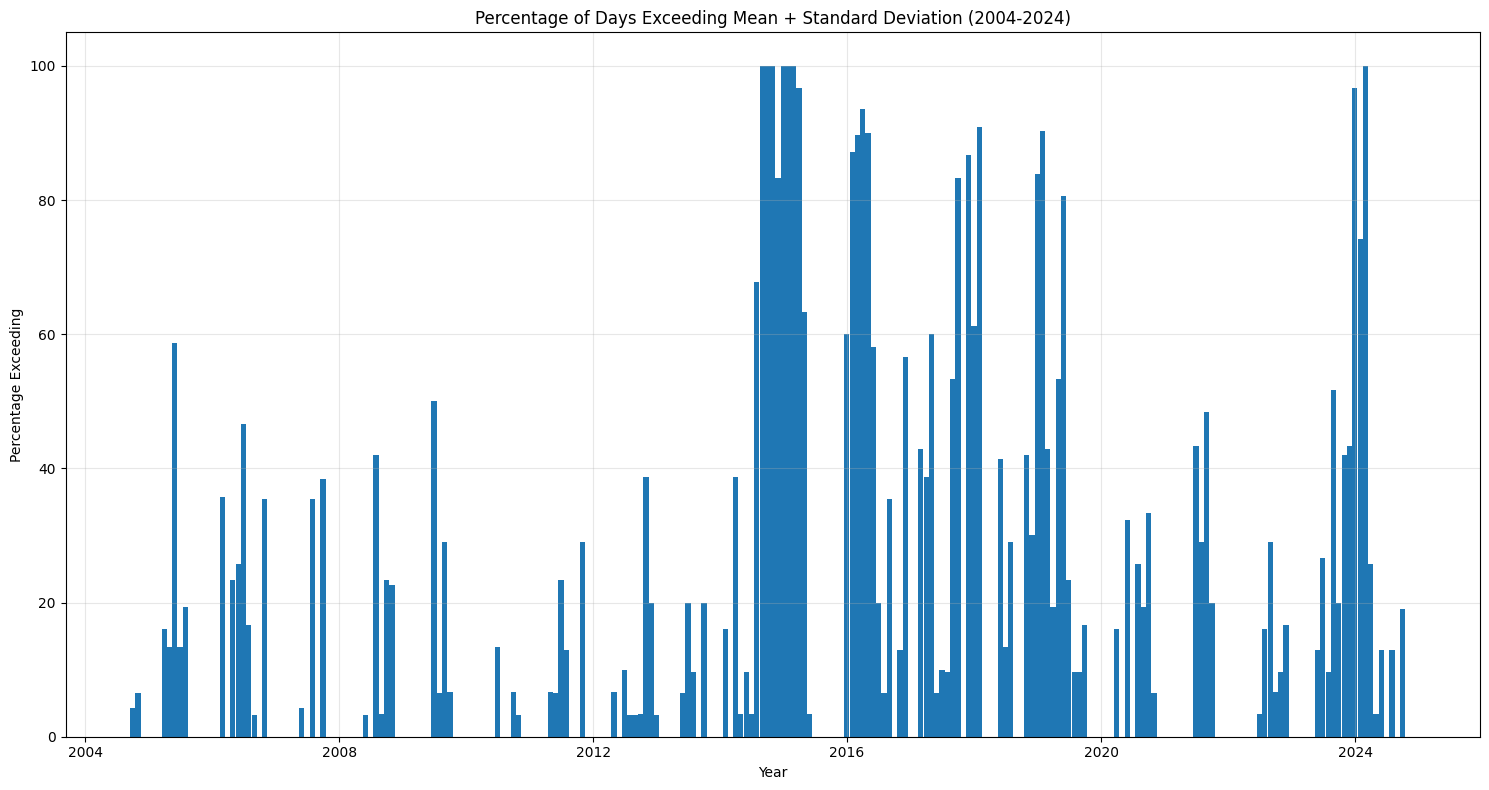

In [15]:
# Convert exceedance_df to a single time series
exceedance_series = []
years = sorted(dfs.keys())  # Get years in order from 2004 to 2024

for year in years:
    # Get the monthly values for this year and add them to our series
    monthly_values = exceedance_df.loc[year]
    exceedance_series.extend(monthly_values)

# Create a date range for plotting
dates = pd.date_range(start='2004-01-01', end='2024-12-31', freq='M')[:len(exceedance_series)]

# Create figure
plt.figure(figsize=(15, 8))

# Plot the bar chart with width set to match the time interval (30 days)
plt.bar(dates, exceedance_series, width=30)  # Monthly data, so ~30 days width

plt.title('Percentage of Days Exceeding Mean + Standard Deviation (2004-2024)')
plt.xlabel('Year')
plt.ylabel('Percentage Exceeding')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Save this data for use in the Livermore airport temperature analysis notebook.

In [16]:
# Create a DataFrame with dates and exceedance values
output_df = pd.DataFrame({
    'date': dates,
    'exceedance_percentage': exceedance_series
})

# Save to CSV file
output_df.to_csv(data / 'buoy_exceedance_data.csv', index=False)


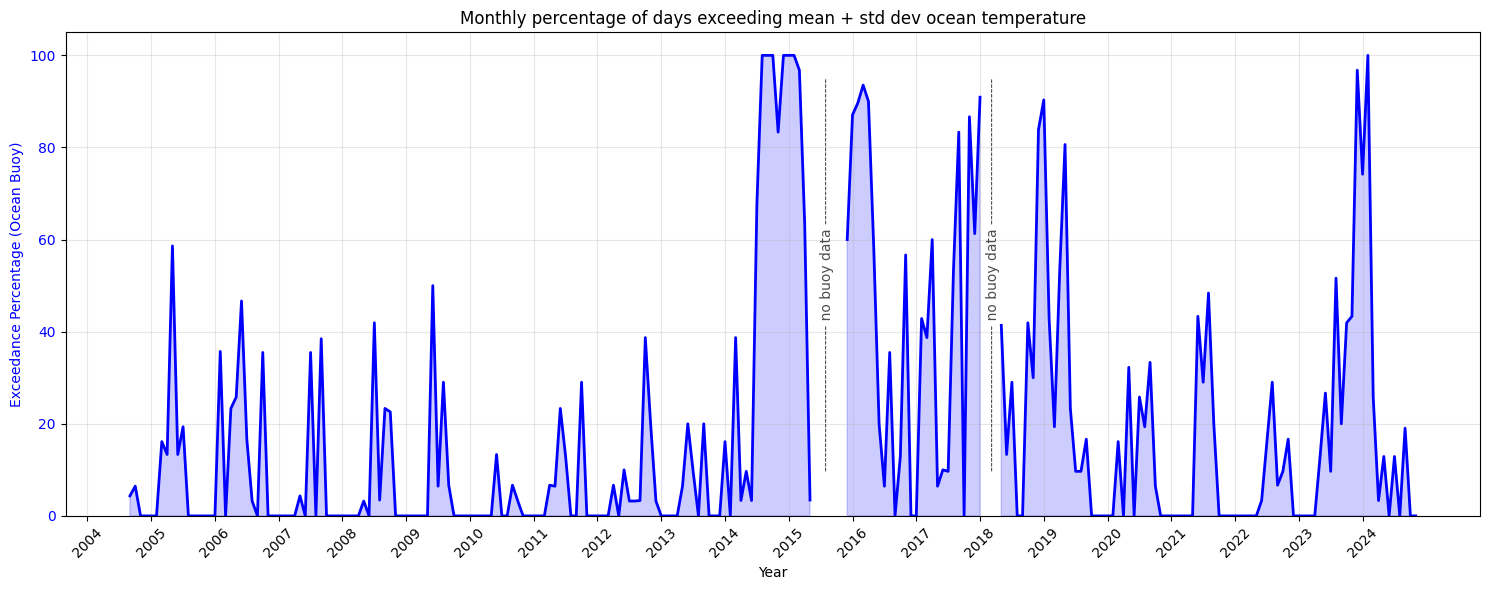

In [26]:
buoy_df = output_df

fig, ax1 = plt.subplots(figsize=(15, 6))

year_ints = [int(year) for year in years]

ax1.set_xlabel('Year')

# Plot monthly buoy data
buoy_df['year_fraction'] = buoy_df['date'].dt.year + (buoy_df['date'].dt.month - 1) / 12
ax1.fill_between(buoy_df['year_fraction'], 
                 buoy_df['exceedance_percentage'],
                 color='blue',  #'navy',
                 alpha=0.2) #0.15)  # Very transparent fill
ax1.plot(buoy_df['year_fraction'], 
         buoy_df['exceedance_percentage'],
         color='blue',  #'navy',
         linewidth=2,
         label='Ocean Buoy Monthly Exceedance %')

no_data_str = "-"*30 + " no buoy data " + "-"*30    
y_mid = ax1.get_ylim()[1] / 2  # Get middle of y-axis
ax1.text(2015.6, y_mid, no_data_str, rotation=90, ha='center', va='center', alpha=0.7)
ax1.text(2018.2, y_mid, no_data_str, rotation=90, ha='center', va='center', alpha=0.7)

plt.title('Monthly percentage of days exceeding mean + std dev ocean temperature')
plt.grid(True, alpha=0.3)

# Format x-axis
ax1.set_xticks(year_ints)
ax1.set_xticklabels(year_ints, rotation=45)

ax1.set_ylabel('Exceedance Percentage (Ocean Buoy)', color='blue')  #'navy')
ax1.tick_params(axis='y', labelcolor='blue')  #'navy')

# Ensure both y-axes start at 0
ax1.set_ylim(bottom=0)

plt.tight_layout()
plt.show()